# Ad feature with raw sample

# Load and Inspect Data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
#raw_df = pd.read_csv('raw_sample.csv')
ad_df = pd.read_csv('ad_feature.csv')

# Preview ad features
print("Ad Feature Columns:\n", ad_df.columns.tolist())
print("\nAd Feature Sample:\n", ad_df.head())

Ad Feature Columns:
 ['adgroup_id', 'cate_id', 'campaign_id', 'customer', 'brand', 'price']

Ad Feature Sample:
    adgroup_id  cate_id  campaign_id  customer     brand   price
0       63133     6406        83237         1   95471.0  170.00
1      313401     6406        83237         1   87331.0  199.00
2      248909      392        83237         1   32233.0   38.00
3      208458      392        83237         1  174374.0  139.00
4      110847     7211       135256         2  145952.0   32.99


![A Sample Ad](ad_sample.jpg)

In [22]:
ad_df.isnull().sum()

adgroup_id          0
cate_id             0
campaign_id         0
customer            0
brand          246330
price               0
dtype: int64

In [23]:
print(ad_df.nunique())

adgroup_id     846811
cate_id          6769
campaign_id    423436
customer       255875
brand           99814
price           14861
dtype: int64


In [2]:
brand_mode = ad_df['brand'].mode()[0]
ad_df['brand'] = ad_df['brand'].fillna(brand_mode)

# Create a missing value indicator
ad_df['brand_missing'] = ad_df['brand'].isnull().astype(int)

In [3]:
missing_values = ad_df.isnull().sum()
print("Missing values in ad_df:\n", missing_values)

Missing values in ad_df:
 adgroup_id       0
cate_id          0
campaign_id      0
customer         0
brand            0
price            0
brand_missing    0
dtype: int64


In [4]:
# Cap price at 95th percentile to handle outliers
price_cap = ad_df['price'].quantile(0.95)
ad_df['price_capped'] = np.where(ad_df['price'] > price_cap, price_cap, ad_df['price'])


In [6]:
price_bins = [0, 50, 100, 200, 500, 1000, 5000, np.inf]
price_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Luxury', 'Super Luxury']

# Create price_level feature
ad_df['price_level'] = pd.cut(ad_df['price'], bins=price_bins, labels=price_labels)

# Merge Datasets

In [ ]:
merged_df = raw_df.merge(ad_df, on='adgroup_id', how='left')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


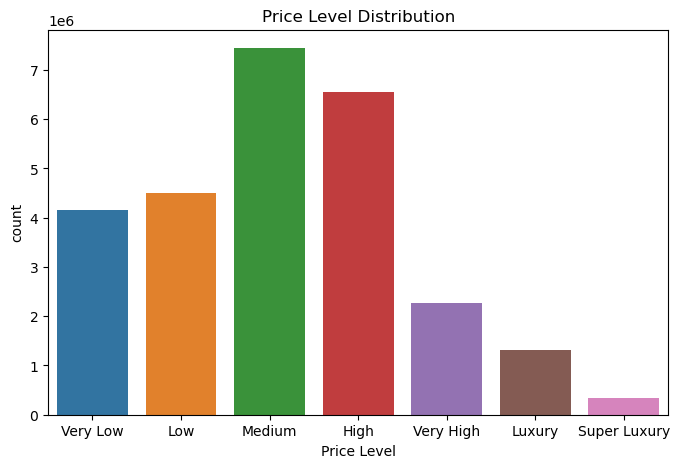

In [31]:
plt.figure(figsize=(8, 5))
sns.countplot(data=merged_df, x='price_level')
plt.title('Price Level Distribution')
plt.xlabel('Price Level')
plt.show()

# Visualization

/var/folders/pp/j448c74s6nqfn2yy018y7pxm0000gn/T/ipykernel_349/798029877.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_level_ctr = merged_df.groupby('price_level')['clk'].mean().reset_index()
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


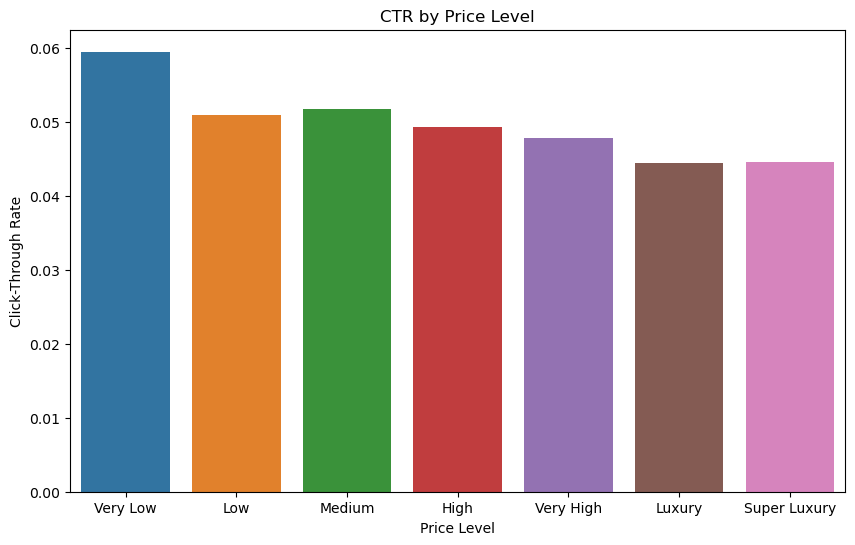

In [8]:
price_level_ctr = merged_df.groupby('price_level')['clk'].mean().reset_index()

# Plot CTR by price_level
plt.figure(figsize=(10, 6))
sns.barplot(data=price_level_ctr, x='price_level', y='clk')
plt.title('CTR by Price Level')
plt.xlabel('Price Level')
plt.ylabel('Click-Through Rate')
plt.show()

In [15]:
ad_df.to_csv('processed_ad_feature.csv', index=False)

merged_df.to_csv('merged_raw_ad_data.csv', index=False)

In [24]:
print(merged_df.columns.tolist())

['user', 'time_stamp', 'adgroup_id', 'pid', 'nonclk', 'clk', 'cate_id', 'campaign_id', 'customer', 'brand', 'price', 'brand_missing', 'price_capped', 'price_level']


In [25]:
import pandas as pd
import numpy as np

# Define feature columns
feature_cols = ['cate_id', 'campaign_id', 'brand', 'customer', 'price_capped', 'price_level']

# Define target variable
target_col = 'clk'

# Create feature matrix X and target vector y
X = merged_df[feature_cols]
y = merged_df[target_col]

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical features
categorical_features = ['cate_id', 'campaign_id', 'brand', 'customer', 'price_level']
numerical_features = ['price_capped']

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

In [27]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss

# Initialize and train the model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_lr, y_train_lr)

# Predict probabilities
y_pred_lr = lr_model.predict_proba(X_test_lr)[:, 1]

# Evaluate the model
auc_lr = roc_auc_score(y_test_lr, y_pred_lr)
logloss_lr = log_loss(y_test_lr, y_pred_lr)

print(f"Logistic Regression AUC: {auc_lr:.4f}")
print(f"Logistic Regression LogLoss: {logloss_lr:.4f}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUC: 0.5887
Logistic Regression LogLoss: 0.2014


In [33]:
from sklearn.preprocessing import LabelEncoder

# Copy features for embedding model
X_embed = X.copy()

# Initialize label encoders for categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_embed[col] = le.fit_transform(X_embed[col].astype(str))
    label_encoders[col] = le

# Scale numerical feature
scaler = StandardScaler()
X_embed['price_capped'] = scaler.fit_transform(X_embed[['price_capped']])


In [34]:
# Split data into training and testing sets
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_embed, y, test_size=0.2, random_state=42, stratify=y
)


In [36]:
import torch
from torch.utils.data import Dataset, DataLoader

class AdClickDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = AdClickDataset(X_train_emb, y_train_emb)
test_dataset = AdClickDataset(X_test_emb, y_test_emb)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

In [37]:
import torch.nn as nn

class EmbeddingMLPModel(nn.Module):
    def __init__(self, input_dim):
        super(EmbeddingMLPModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x).squeeze()


In [38]:
# Initialize model, loss function, and optimizer
input_dim = X_train_emb.shape[1]
model = EmbeddingMLPModel(input_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: 5.1664
Epoch 2/5, Loss: 5.1438
Epoch 3/5, Loss: 5.1438
Epoch 4/5, Loss: 5.1438
Epoch 5/5, Loss: 5.1437


In [39]:
from sklearn.metrics import roc_auc_score, log_loss

# Evaluation
model.eval()
y_pred_nn = []
y_true_nn = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_pred_nn.extend(outputs.numpy())
        y_true_nn.extend(y_batch.numpy())

# Calculate metrics
auc_nn = roc_auc_score(y_true_nn, y_pred_nn)
logloss_nn = log_loss(y_true_nn, y_pred_nn)

print(f"Embedding + MLP AUC: {auc_nn:.4f}")
print(f"Embedding + MLP LogLoss: {logloss_nn:.4f}")


Embedding + MLP AUC: 0.5000
Embedding + MLP LogLoss: 1.8540
